In [1]:
import torch 
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [49]:
class SARDespeckleModel(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.initial_stack = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.middle_stack = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(num_features=hidden_units),
                    nn.ReLU()
                )
                for _ in range(6)
            ]
        )
        self.final_stack = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
    
        self.tanh_layer = nn.Tanh()

    def forward(self, initial:torch.Tensor):
        x = self.initial_stack(initial)
        x = self.middle_stack(x)
        res = self.final_stack(x)
        despeckle = initial/(res + 1e-8)
        img = self.tanh_layer(despeckle)
        return img


In [50]:
model = SARDespeckleModel(
    input_shape=1,
    hidden_units=64,
    output_shape=1
)

model.load_state_dict(torch.load('models/sar_model', map_location=torch.device('cuda'), weights_only=True))

<All keys matched successfully>

In [54]:
transform = transforms.Compose([
    transforms.ToTensor()
])

def process_image(image):
    image = Image.open(image)
    image = transform(image).unsqueeze(0)
    return image

def predict_image(image):
    with torch.no_grad():
        output = model(image)
        # print(f'output: {output}')
    # ouput_img = transforms.ToPILImage(output.squeeze())
    output_img = output.squeeze(0)
    return output_img

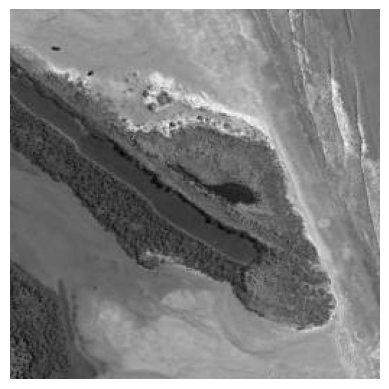

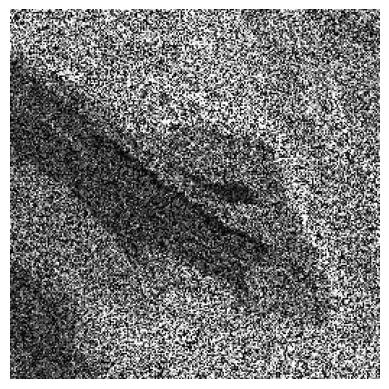

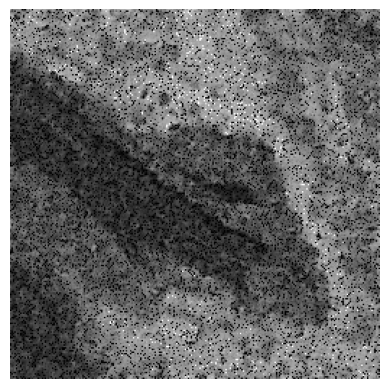

In [57]:
sample_clean = process_image('samples/clean/31498.jpg')
sample_noise = process_image('samples/noisy/31498.jpg')
sample_predict = predict_image(sample_noise)

plt.imshow(sample_clean.squeeze(0).squeeze(0), cmap='gray')
plt.axis(False)
plt.show()

plt.imshow(sample_noise.squeeze(0).squeeze(0), cmap='gray')
plt.axis(False)
plt.show()

plt.imshow(sample_predict.squeeze(0), cmap='gray')
plt.axis(False)
plt.show()

# print(f"sample noise: {sample_noise}")